### Pixels to mm^2: Takes image with a known length (# x # mm square) and calculates pixels-to-millimeter scale

In [25]:
import sys
# Change to repository root, so it can find the config folder with the paths inside it
GITHUB_REPO_PATH = '/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj'
# Add config folder with paths to Python's import search path
if GITHUB_REPO_PATH not in sys.path:
    sys.path.insert(0, GITHUB_REPO_PATH)

import config.paths as paths
print(paths.__file__)

/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/config/paths.py


In [22]:
# matplot only needed on Jupyter Lab - Comment on Python
%matplotlib widget
import matplotlib.pyplot as plt

from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import os
import numpy as np
import json

In [27]:


files = [f for f in os.listdir(image_dir) if not f.startswith(".")]
if len(files) == 0:
    raise FileNotFoundError(f"No files found in {image_dir}.")
elif len(files) > 1:
    print(f"Warning: More than one image in {image_dir}, using one.")
filename = files[0]
image_name = filename
print(f"Image Name: {image_name}")
image_path = os.path.join(image_dir, image_name)

# Change to folder in which Pixels_to_mm takes place, leave final part before .json (name of the file after the path)
num_pixels_in_squares_path = paths.t1_temp_pixel_results
scale_values = paths.t1_scale_values_path

AttributeError: module 'config.paths' has no attribute 't1_calibration_image_path'

In [3]:
# Inputs/Outputs for PlantCV
args = WorkflowInputs(
    images=[image_path],
    names="image1",
    result=num_pixels_in_squares_path,
    outdir=".",
    writeimg=False,
    debug="plot"
    )

# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

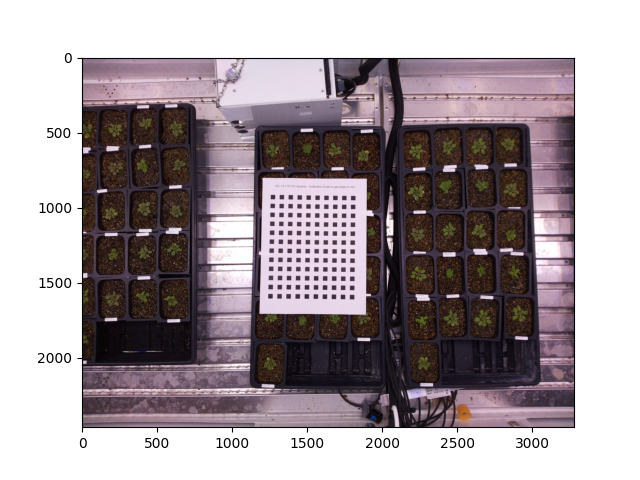

In [4]:
# Shows your image, defines it as "img"
img, path, filename = pcv.readimage(filename=args.image1)

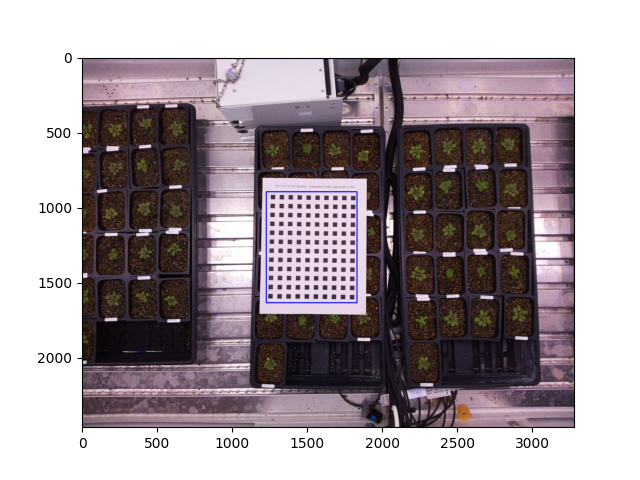

In [6]:
# Crops your image
crop_img = pcv.crop(img=img, x=1228, y=897, w=1834-1228, h=1637-897)

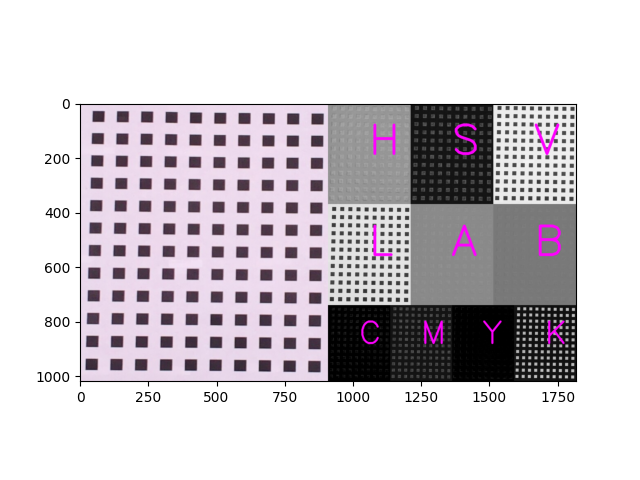

In [7]:
# Shows options for which channel to view the image through (ideally want the most contrast)
colorspace_img = pcv.visualize.colorspaces(rgb_img=crop_img)

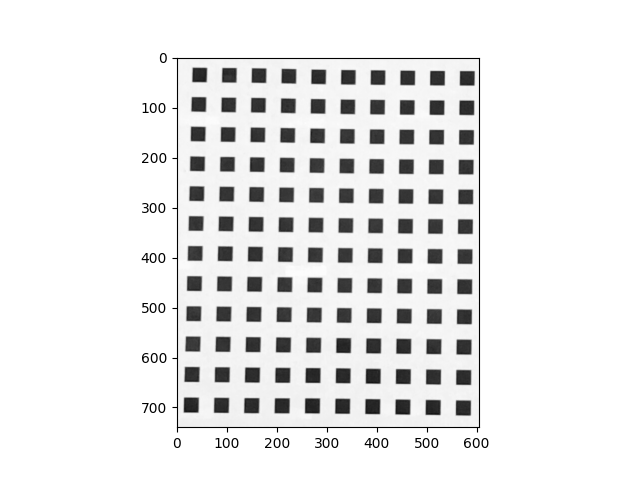

In [8]:
# Actually picks a channel with rgb2gray_"lab" and then the channel is the letter from "lab" that you look through
l_img = pcv.rgb2gray_lab(rgb_img=crop_img, channel='l')

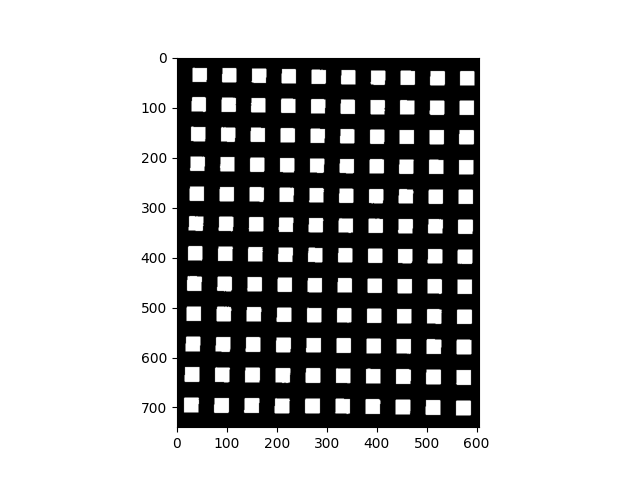

In [9]:
# Masks the image, saving only the dark squares
thresh_mask = pcv.threshold.binary(gray_img=l_img, threshold=140, object_type='dark')

# Only uncomment if extra bits on your Calibration Sheet - Deletes groups of pixels less than the pixel size (weird dots around edges not plant is unmasked)
# cleaned_mask = pcv.fill(bin_img=thresh_mask, size=3000)

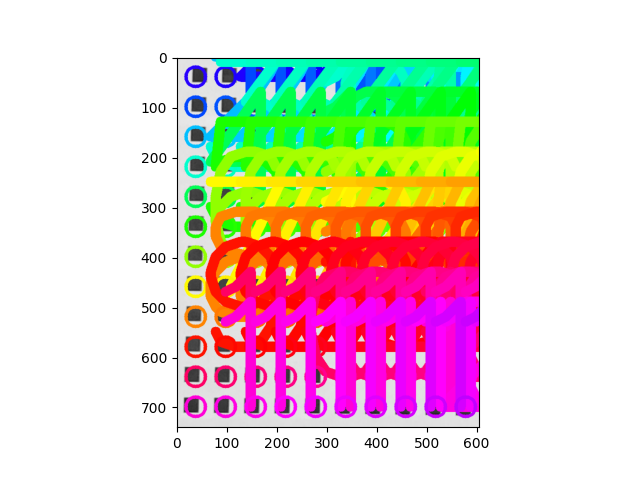

In [10]:
# Makes ROI based on how many Calibration Squares you have (Change rows and columns)
auto_rois = pcv.roi.auto_grid(mask=thresh_mask, nrows=12, ncols=10, img=l_img)

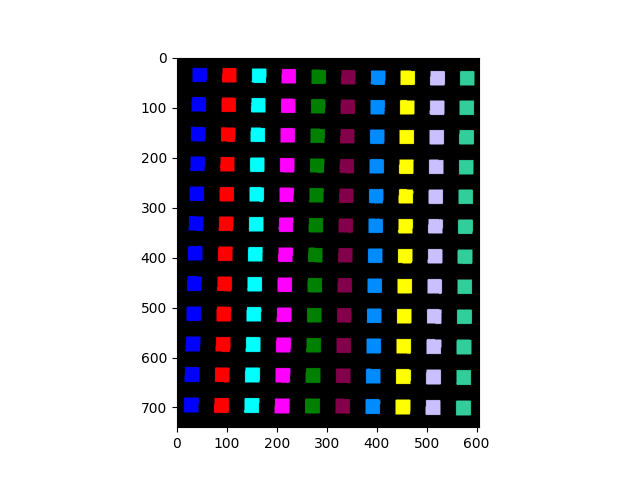

In [11]:
# Label and number objects in ROI; A good check to ensure different squares are different objects from being different colors
labeled_mask, num_squares = pcv.create_labels(mask=thresh_mask, rois=auto_rois, roi_type='partial')

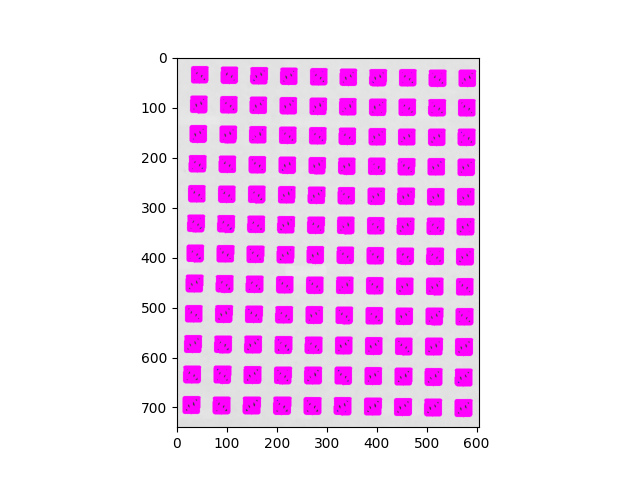

In [13]:
# Outputs analyzed image (width/height of squares)
shape_image = pcv.analyze.size(img=l_img, labeled_mask=labeled_mask, n_labels=num_squares)

In [14]:
# Saves results for the 1 image (running again overwites past results)
pcv.outputs.save_results(filename= args.result, outformat="json")

In [15]:
# Takes average scalar s (mm per pixel) for all 1x1 mm squares:
area_square_mm = 86.49 # ~9.3 mm per side of square
number_of_squares = 120
s_list = []

for i in range(number_of_squares):
    i = i+1
    pixels_area = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    s_per_square = (area_square_mm / pixels_area) ** 0.5
    s_list.append(s_per_square)

scales = np.array(s_list)

mean_scale_mm_per_pixel = np.mean(scales)
std_scale_mm_per_pixel = np.std(scales, ddof=1)

print(f"Mean Scale: {mean_scale_mm_per_pixel} mm/pixel")
print(f"Standard Deviation: {std_scale_mm_per_pixel}")
print(f"Rounded Scale: {mean_scale_mm_per_pixel:.5f} ± {std_scale_mm_per_pixel:.5f} mm/pixel")

Mean Scale: 0.32007291370564833 mm/pixel
Standard Deviation: 0.003998317642829697
Rounded Scale: 0.32007 ± 0.00400 mm/pixel


In [16]:
# Saves scale values to a json file to be read by the image processor
scale_data = {
    "mean_scale_mm_per_pixel": mean_scale_mm_per_pixel,
    "std_scale_mm_per_pixel": std_scale_mm_per_pixel
}

with open(scale_values, "w") as f:
    json.dump(scale_data, f)

In [15]:
# Unused Versions for finding scalar pixels_to_mm: Average side length and average area to find s - best way is to average scalar values themselves

# # Finds average side length of 1 mm square to provide scalar value of pixels-to-mm scale s
# side_total = 0
# for i in range(3):
#     i = i+1
#     pixels_width = pcv.outputs.observations[f"default_{i}"]["width"]["value"]
#     pixels_height = pcv.outputs.observations[f"default_{i}"]["height"]["value"]
#     side_total = side_total + pixels_width + pixels_height

# number_of_calibration_squares = 3
# known_calibration_square_area = 1
# avg_side_length = side_total/(2 * number_of_calibration_squares)
# area_calibration_squares_in_pixels = avg_side_length ** 2
# mm_per_pixel = (known_calibration_square_area / area_calibration_squares_in_pixels) ** 0.5

# print(f"Average side length of squares (should be ~30): {avg_side_length}")
# print(f"Area of squares in pixels (should be ~900): {area_calibration_squares_in_pixels}")
# print(f"Scale = {mm_per_pixel}, mm/pixel")

# # Takes average area of 1x1 mm squares to provide scalar value of pixels-to-mm scale s
# area_total = 0
# for i in range(3):
#     i = i+1
#     pixels_area = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
#     area_total = area_total + pixels_area

# number_of_calibration_squares = 3
# known_calibration_square_area = 1
# avg_area_calibration_squares_in_pixels = area_total / 3
# mm_per_pixel = (known_calibration_square_area / avg_area_calibration_squares_in_pixels) ** 0.5

# print(f"Area of squares in pixels (should be ~900): {avg_area_calibration_squares_in_pixels}")
# print(f"Scale = {mm_per_pixel}, mm/pixel")

In [16]:
plt.close('all')